In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation')
%matplotlib notebook
colors_cycle=plt.rcParams.get('axes.prop_cycle')
colors = [item['color'] for item in colors_cycle]

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

[1] M. Villalva, J. Gazoli, and E. Filho, “Comprehensive Approach to Modeling and Simulation of Photovoltaic Arrays,” IEEE Trans. Power Electron., vol. 24, no. 5, pp. 1198–1208, 2009.

In [2]:
T = 273.4+25
V = 25.0
G = 800.0
q = 1.60217646e-19 # C
k = 1.3806503e-23 # J/K

I_mp = 7.61
V_mp = 26.3
P_maxn = 200.143
I_scn = 8.21
V_ocn = 32.9
I_0n = 9.825e-8
I_pvn = I_scn
G_n = 1000.0
a = 1.3
R_p = 415.405
R_s = 0.221
K_i = 0.0032
K_v = -0.1230
T_n =  273.4+25
N_s = 54
#I = I_pv_cell - I_0_cell*(np.exp(q*V/(a*k*T))-1) 

#Ipv,n (in amperes) is the light-generated current at the nominal condition
Dtemp = T - T_n
V_tn = N_s*k*T_n/q
V_t = N_s*k*T/q

I_pv = (I_pvn + K_i*Dtemp)*G/G_n 
I_0n = I_scn/(np.exp(V_ocn/(a*V_tn))-1)
#I_0 = I_0n*(T_n/T)**3*np.exp(w*E_g/(a*k)*(1/T_n-1/T))
I_0 = (I_scn + K_i*Dtemp)/(np.exp((V_ocn + K_v * Dtemp)/(a*V_t))-1)
I = I_pv
for it in range(500):
    I_prev = I
    I = I_pv - I_0*(np.exp((V+R_s*I)/(V_t*a))-1) - (V+R_s*I)/R_p 
    if np.abs(I_prev - I)<1.0e-4: 
        print(it)
        break

#-I_0*R_s*exp((I*R_s + V)/(V_t*a))/(V_t*a) - 1 - R_s/R_p
print(I)

3
6.28178825611


In [3]:
I,I_pv,I_0,V,R_s,V_t,a,R_p = sym.symbols('I,I_pv,I_0,V,R_s,V_t,a,R_p')  

eq = -I + I_pv - I_0*(sym.exp((V+R_s*I)/(V_t*a))-1) - (V+R_s*I)/R_p 

J = sym.diff(eq,I)
'''    
'''

s = sym.solve([ eq],
              [I])


I =  I_pv - I_0*(sym.exp((V+R_s*I)/(V_t*a))-1) - (V+R_s*I)/R_p 


In [4]:

@numba.jit(nopython=True, cache=True)
def b2b_ctrl1(struct,i,m):
    '''
    Doubly Fed Induction Machine in with neglected dynamics and
    rotor side converter and control level 1 already implemented.
    i_rd = i_rd_ref and i_rq = i_rq_ref without dynamics 
    '''

    x_idx = struct[i]['b2b_idx']
    v_dc = float(struct[i]['x'][x_idx+0,0])
    
    L_1 = struct[i]['L_1']
    L_2 = struct[i]['L_2']
    R_1 = struct[i]['R_1']
    R_2 = struct[i]['R_2']
    C_dc = struct[i]['C_dc']

    omega_1 = struct[i]['omega_1']
    omega_2 = struct[i]['omega_2']
       
    i_1d_ref = struct[i]['i_1d_ref'] 
    i_1q_ref = struct[i]['i_1q_ref'] 
    i_2d_ref = struct[i]['i_2d_ref'] 
    i_2q_ref = struct[i]['i_2q_ref'] 
    
    i_1d = i_1d_ref
    i_1q = i_1q_ref
    i_2d = i_2d_ref
    i_2q = i_2q_ref
    
    v_1d = struct[i]['v_1d']
    v_1q = struct[i]['v_1q']
    v_2d = struct[i]['v_2d']
    v_2q = struct[i]['v_2q']
    
    
    eta_1d = 2.0*(R_1*i_1d - L_1*i_1q*omega_1 + v_1d)/v_dc
    eta_1q = 2.0*(R_1*i_1q + L_1*i_1d*omega_1 + v_1q)/v_dc
    eta_2d = 2.0*(R_2*i_2d - L_2*i_2q*omega_2 + v_2d)/v_dc
    eta_2q = 2.0*(R_2*i_2q + L_2*i_2d*omega_2 + v_2q)/v_dc
    
    i_dc_1 = 3.0/4.0*(eta_1d*i_1d + eta_1q*i_1q)
    i_dc_2 = 3.0/4.0*(eta_2d*i_2d + eta_2q*i_2q)    
    dv_dc = 1.0/C_dc*(-i_dc_1 - i_dc_2)
    
    struct[i]['eta_1d'] = eta_1d
    struct[i]['eta_1q'] = eta_1q
    struct[i]['eta_2d'] = eta_2d
    struct[i]['eta_2q'] = eta_2q
    struct[i]['i_dc_1'] = i_dc_1
    struct[i]['i_dc_2'] = i_dc_2
    
    struct[i]['p_1'] = 3.0/2.0*(v_1d*i_1d + v_1q*i_1q)
    struct[i]['q_1'] = 3.0/2.0*(v_1d*i_1q - v_1q*i_1d)

    struct[i]['p_2'] = 3.0/2.0*(v_2d*i_2d + v_2q*i_2q)
    struct[i]['q_2'] = 3.0/2.0*(v_2d*i_2q - v_2q*i_2d)
    
    struct[i]['f'][x_idx+0,0] = dv_dc
    
    return 0


In [5]:
@numba.jit(nopython=True, cache=True)
def b2b_ctrl2(struct,i,m):
    '''
    Control level 2 for DC Voltage
    
    '''
    
    x_idx = struct[i]['b2b_ctrl_idx']
    xi_v_dc = float(struct[i]['x'][x_idx+0,0]) 

    S_b = struct[i]['S_b']
    V_dc_b = struct[i]['V_dc_b']
    
    K_v_p = struct[i]['K_v_p']
    K_v_i = struct[i]['K_v_i']  

    v_dc = struct[i]['v_dc']
        
    v_dc_ref = struct[i]['v_dc_ref']
    p_1_ref = struct[i]['p_1_ref']
    q_1_ref = struct[i]['q_1_ref']  
    p_2_ref = struct[i]['p_2_ref']
    q_2_ref = struct[i]['q_2_ref']  

    v_1d = struct[i]['v_1d']
    v_1q = struct[i]['v_1q']
    v_2d = struct[i]['v_2d']
    v_2q = struct[i]['v_2q']
    
    error_v_dc = (v_dc - v_dc_ref)/V_dc_b
    
    p_ref = (K_v_p * error_v_dc + K_v_i*xi_v_dc)*S_b
    
    if struct[i]['vdc_ctrl'] == 1:
        p_ref_1 = p_ref

    if struct[i]['vdc_ctrl'] == 2:
        p_ref_2 = p_ref
        
    den = (v_1d**2 + v_1q**2)
    
    den_1 = 0.001
    if den_1 > 0.0:
        den_1 = (v_1d**2 + v_1q**2)

    den_2 = 0.001
    if den_2 > 0.0:
        den_2 = (v_2d**2 + v_2q**2)
        
    i_1d_ref = 2.0/3.0*(p_1_ref*v_1d - q_1_ref*v_1q)/den_1
    i_1q_ref = 2.0/3.0*(p_1_ref*v_1q + q_1_ref*v_1d)/den_1
    
    i_2d_ref = 2.0/3.0*(p_2_ref*v_2d - q_2_ref*v_1q)/den_2
    i_2q_ref = 2.0/3.0*(p_2_ref*v_2q + q_2_ref*v_1d)/den_2
    
    struct[i]['i_1d_ref'] = i_1d_ref
    struct[i]['i_1q_ref'] = i_1q_ref
    struct[i]['i_2d_ref'] = i_2d_ref
    struct[i]['i_2q_ref'] = i_2q_ref
   
    dxi_v_dc = error_v_dc
   
    struct[i]['f'][x_idx+0,0] = dxi_v_dc
 
    return 0


In [6]:
T_a = 25.0
G = 200.0
I_scstc = 2.954 # Corriente cortocircuito celula PV [A]
V_ocstc = 1.87 #  Tension circuito abierto celula PV [V]
V_mppstc = 1.51 # Tension maxima potencia celula PV [V]
I_mppstc = 2.77 # Imppstc Corriente maxima potencia celula PV [A]
T_ONC = 20.0 # Temperatura operacion nominal celula PV [C]
N_cs = 20.0 # Numero de celulas serie modulo PV [uds]
N_cp = 3 # Numero de ramas paralelo modulo PV [uds]
N_ms = 26 # Numero de modulos serie generador PV [uds]
N_mp = 155 # Numero de ramas paralelo generador PV [uds]


FF=( V_mppstc*I_mppstc )/( V_ocstc*I_scstc) 
T_c=T_a+G*(T_ONC -20)/800 
V_t =0.025*( T_c +273)/300 
nuoc=V_ocstc/V_t 
FF0=(nuoc -np.log(nuoc +0.72))/( nuoc +1) 
rs=1-FF/FF0 
Rs=rs*V_ocstc/I_scstc 
kct =0.001*T_a +0.7976
I_sc=I_scstc *(G/1000) 
V_oc=V_ocstc -0.0023*(T_c -25) 
a=nuoc +1-2* nuoc*rs 
b=a/(1+a) 
aux=1/pow(a,b)
V_int=V_oc*(1-(b/nuoc)*np.log(a)-rs*(1-aux ))* N_cs*N_ms

In [7]:
@numba.jit(nopython=True, cache=True)
def pv_fit(struct,i,m):

    
    T = struct[i]['T'] # 
    V = struct[i]['V'] # 
    G = struct[i]['G'] #  

    Q = struct[i]['Q'] # 
    K = struct[i]['K'] #     I_mp  = struct[i]['I_mp'] #  
    V_mp = struct[i]['V_mp']  #  
    P_maxn = struct[i]['P_maxn'] #  
    I_scn = struct[i]['I_scn'] # #  
    V_ocn = struct[i]['V_ocn'] #  
    I_0n = struct[i]['I_0n']   #  
    I_pvn = struct[i]['I_pvn'] #   
    G_n = struct[i]['G_n']     #   
    a = struct[i]['a']         #   

    R_p = struct[i]['R_p'] #   
    R_s = struct[i]['R_s'] #  
    K_i = struct[i]['K_i'] #   
    K_v = struct[i]['K_v'] #   
    T_n = struct[i]['T_n'] #   
    N_s = struct[i]['N_s'] #   
    
    #I = I_pv_cell - I_0_cell*(np.exp(q*V/(a*k*T))-1) 

    #Ipv,n (in amperes) is the light-generated current at the nominal condition
    Dtemp = T - T_n
    V_tn = N_s*k*T_n/q
    V_t = N_s*k*T/q

    I_pv = (I_pvn + K_i*Dtemp)*G/G_n 
    I_0n = I_scn/(np.exp(V_ocn/(a*V_tn))-1)
    #I_0 = I_0n*(T_n/T)**3*np.exp(w*E_g/(a*k)*(1/T_n-1/T))
    I_0 = (I_scn + K_i*Dtemp)/(np.exp((V_ocn + K_v * Dtemp)/(a*V_t))-1)
    I = I_pv
    for it in range(20):
        I_prev = I
        I = I_pv - I_0*(np.exp((V+R_s*I)/(V_t*a))-1) - (V+R_s*I)/R_p 
        if np.abs(I_prev - I)<1.0e-4: 

            break
    #-I_0*R_s*exp((I*R_s + V)/(V_t*a))/(V_t*a) - 1 - R_s/R_p

    P = I*V
    
    struct[i]['I'] = I
    struct[i]['P'] = P

    return 0


#@numba.jit(nopython=True, cache=True)
def mppt_pv_indcond(struct,i,m):

    V = struct[i]['V'] # 
    I = struct[i]['I'] #     
    V_prev = struct[i]['V_prev'] # 
    I_prev = struct[i]['I_prev'] #       
    v_mppt = float(struct[i]['v_mppt']) # 
    inc = struct[i]['inc'] # 
    
    DV = V - V_prev
    DI = I - I_prev
    
    if DV == 0.0:
        if not DI == 0.0:
            if DI>0.0:
                v_mppt -= inc
            else:
                v_mppt += inc
                
    if not DV == 0.0:
        if not DI/DV == -I/V:
            if DI/DV > -I/V:
                v_mppt += inc
            if DI/DV < -I/V:
                v_mppt = v_mppt - inc

                
    V_prev = float(V)
    I_prev = float(I)

    if v_mppt<10: v_mppt = 10.0        
    struct[i]['V_prev'] = float(V_prev)
    struct[i]['I_prev'] = float(I_prev)    
    struct[i]['v_mppt'] = v_mppt
    return v_mppt



In [8]:
200/(1000*1.49*0.9)

0.14914243102162567

In [9]:
a -= 0.1
a

48.199642147636027

In [10]:
d =dict(T = 273.4+25,
        V = 42.0,
        G = 200.0,
        Q = 1.60217646e-19, # C
        K = 1.3806503e-23, # J/K
        I_mp = 7.61,
        V_mp = 26.3,
        P_maxn = 200.143,
        I_scn = 8.21,
        V_ocn = 32.9,
        I_0n = 9.825e-8,
        I_pvn = 8.21,
        G_n = 1000.0,
        a = 1.3,
        R_p = 415.405,
        R_s = 0.221,
        K_i = 0.0032,
        K_v = -0.1230,
        T_n =  273.4+25,
        N_s = 54,  
        P = 0.0, 
        I = 10.0, 
        V_prev = 20.0,
        I_prev = 10.0,
        inc= 0.01,
        v_mppt = 20.0,
        )

struct = d2np(d)
i=0
m=2
struct[i]['G'] = 800
struct[i]['V'] = 25
struct[i]['T'] = 45+273.4
pv_fit(struct,i,m)
print(struct[i]['V'])
print(struct[i]['I'])
print(struct[i]['P'])




25.0
5.62023215256
140.505803814


<IPython.core.display.Javascript object>


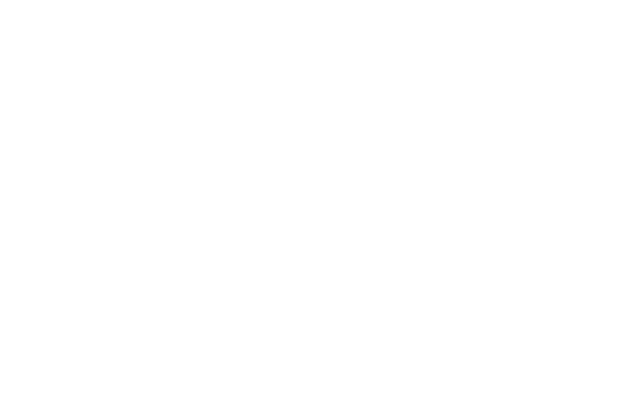

In [11]:
V = []
P = []
struct['v_mppt'] = 22
struct[i]['G'] = 1000
struct[i]['V'] = 25
struct[i]['T'] = 25+273.4
struct[i]['inc'] = 0.1
for it in range(1000):
    
    
    
    struct['V'] = float(struct['v_mppt'])
    mppt_pv_indcond(struct,i,m)
    v_mppt = float(struct['v_mppt'])
    if v_mppt>27: v_mppt=27
    pv_fit(struct,i,m)
    V += [v_mppt]
    P += [float(struct['P'])]
    #print(struct['V'], struct[i]['P'])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex = True)
axes[0].plot(np.array(V))
axes[1].plot(np.array(P))

<IPython.core.display.Javascript object>


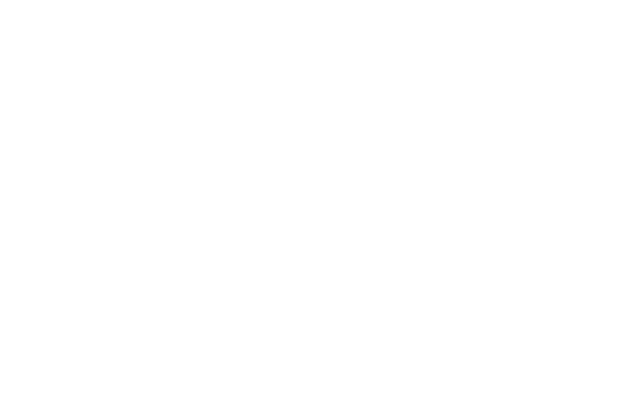

In [12]:
struct = d2np(d)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

for irrad in [200,400,600,800,1000]:
    V = []
    I = []
    G = []
    Irrad = []
    for v in np.linspace(0,32,500):
        struct['G'] = irrad
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
        G += [float(struct['G'])]
        if v==0.0: I_max = float(struct['I'])
    axes.plot(np.array(V),np.array(I))
    axes.set_ylabel('$\sf I \,(A) $')
    axes.set_xlabel('$\sf V \,(V)$')
    axes.set_ylim([0,10])
    #axes.set_xlim([0,22])
    #struct[0]['c_p']
    axes.text(2, I_max+0.2, '$\sf {:2.0f}\, W/m^2$'.format(irrad), fontsize=15)
    
fig.savefig('V_I_Q.svg', bbox_inches='tight')



<IPython.core.display.Javascript object>


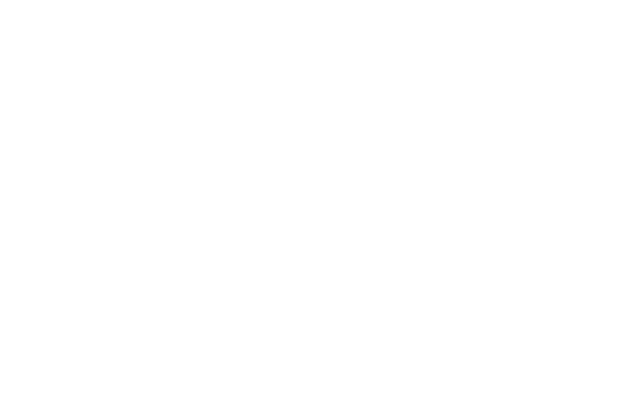

In [13]:
struct = d2np(d)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
struct['G'] = 800
for T,V_max in zip([25,50,75],[32.7,30,27]):
    V = []
    I = []
    G = []
    Irrad = []
    for v in np.linspace(0,V_max,1000):
        struct['T'] = T+273.4
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
    axes.plot(np.array(V),np.array(I), label = '$\sf {:2.0f}\, ºC$'.format(T))
    axes.set_ylabel('$\sf I (A)$')
    axes.set_xlabel('$\sf V (V)$')
    axes.set_ylim([0,10])
    #axes.set_xlim([0,22])
    #struct[0]['c_p']
axes.legend(loc='lower center')   
fig.savefig('V_I_T.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


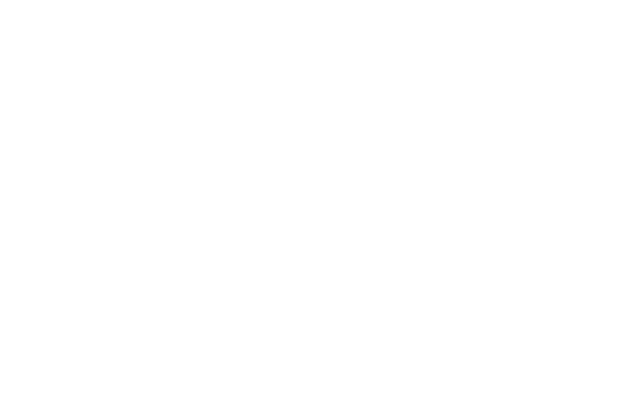

In [14]:
struct = d2np(d)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

for irrad in [200,400,600,800,1000]:
    V = []
    I = []
    G = []
    Irrad = []
    for v in np.linspace(0,32,500):
        struct['G'] = irrad
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
        G += [float(struct['G'])]
    ax1.plot(np.array(V),np.array(I), '--')
    ax1.set_ylabel('$\sf I (A) $')
    ax1.set_xlabel('$\sf V (V)$')
    ax1.set_ylim([0,10])
    ax1.set_xlim([0,22])
    #struct[0]['c_p']

#axes.set_prop_cycle(None)
#ax1.plot(pd.Series(np.random.uniform(0,1,size=10)))
ax2 = ax1.twinx()

for irrad in [200,400,600,800,1000]:
    V = []
    I = []
    P = []
    Irrad = []
    for v in np.linspace(0,32*(irrad/100000+1),500):
        struct['G'] = irrad
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
        P += [float(struct['P'])]
        if v==0.0: I_max = float(struct['I'])
    ax2.plot(np.array(V),np.array(P), label = '$\sf {:2.0f}\, W/m^2$'.format(irrad))
    ax2.set_ylabel('$\sf P (W)$')
    ax2.set_xlabel('$\sf V (V)$')
    #axes.set_ylim([0,10])
    ax2.set_ylim([0,210])
    
    ax1.text(2, I_max+0.2, '$\sf {:2.0f}\, W/m^2$'.format(irrad), fontsize=12)
    
    #struct[0]['c_p']

#ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()    
fig.savefig('V_I_Q_P.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


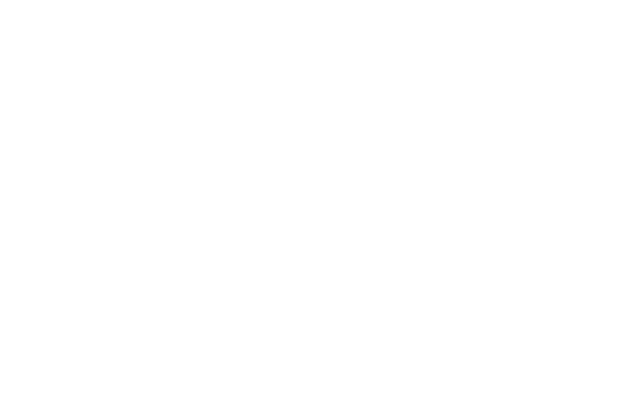

In [15]:
struct = d2np(d)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
struct['G'] = 800
for T,V_max in zip([25,50,75],[32.7,30,27]):
    V = []
    I = []
    G = []
    Irrad = []
    for v in np.linspace(0,V_max,1000):
        struct['T'] = T+273.4
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
    ax1.plot(np.array(V),np.array(I),'--')
    ax1.set_ylabel('$\sf I \,(A) $')
    ax1.set_xlabel('$\sf V \,(V) $')
    ax1.set_ylim([0,10])
    #axes.set_xlim([0,22])
    #struct[0]['c_p']

ax2 = ax1.twinx()
    
for T,V_max in zip([25,50,75],[32.7,30,27]):
    V = []
    I = []
    P = []
    Irrad = []
    for v in np.linspace(0,V_max,500):
        struct['T'] = T+273.4
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
        P += [float(struct['P'])]
    P = np.array(P)
    V = np.array(V)
    ax2.plot(V,P, label = '$\sf {:2.0f}\, ºC$'.format(T))
    ax2.set_ylabel('$\sf P \, (W)$')
    ax2.set_xlabel('$\sf V \, (V)$')
    #axes.set_ylim([0,10])

    ax2.set_ylim([0,210])
    #struct[0]['c_p']
ax2.legend(loc='lower center')    
plt.tight_layout()    
fig.savefig('V_I_T_P.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


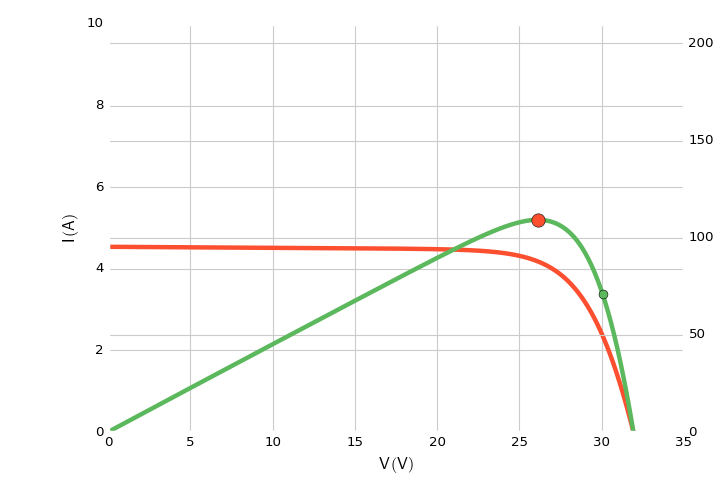

In [16]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 
struct = d2np(d)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6), sharex = True)
fig.set_animated(True)

ax2 = ax1.twinx()

ax1.set_ylabel('$\sf I \,(A) $')
ax1.set_xlabel('$\sf V \,(V) $')
    
ax2.set_ylabel('$\sf P \, (W)$')
ax2.set_xlabel('$\sf V \, (V)$')
    
v_i_line = ax1.plot([], color= colors[0], ms=8) 
v_p_line = ax2.plot([], color= colors[1], ms=8) 
v_pmax_line = ax2.plot([], 'o', ms=12) 
v_mppt_line = ax2.plot([], 'o', ms=8) 
#axes.plot([struct[0]['Omega_t_max']]*2,[-10,10], '--', ms=2, color='k') 
#axes.plot([struct[0]['Omega_t_min']]*2,[-10,10], '--', ms=2, color='k') 
#axes.plot([-10,10], [struct[0]['P_t_n']/1.0e6]*2, '--', ms=2, color='k') 

#p_mppt_line = axes.plot(np.array(omegas_opt),np.array(p_ref_opt)/1e6) 
#p_mppt_point = axes.plot(0.0,0.0, 'or', ms=12)
ax1.set_ylim([0,10])
ax2.set_ylim([0,210])
  
ax1.set_xlim([0,35])
ax2.set_xlim([0,35])

ax1.grid(True)

def update(G,T,court):
    I = []
    P = []
    V = []
    
    struct['G'] = G   
    struct['T'] = T+273.4

    V_max = (100-T)/9+24
    for v in np.linspace(0,V_max,500):
        struct['V'] = v
        pv_fit(struct,0,0)
        V += [float(struct['V'])]
        I += [float(struct['I'])]
        P += [float(struct['P'])]
        
    P = np.array(P)
    V = np.array(V)
    I = np.array(I)    
    #axes.plot(Omega,np.array(P_w)/1e6)
    v_i_line[0].set_xdata(V)
    v_i_line[0].set_ydata(I)
    v_p_line[0].set_xdata(V)
    v_p_line[0].set_ydata(P)

    idx = np.argmax(P)   
    v_pmax_line[0].set_xdata(V[idx])
    v_pmax_line[0].set_ydata(P[idx])    
    
    struct['V_prev'] = V[idx]
    struct['I_prev'] = I[idx]
    struct['V'] = V[idx]
    struct['I'] = I[idx]
    for it in range(500):
        
        struct['V'] -= court*0.5
        mppt_pv_indcond(struct,i,m)
        struct['V'] = np.copy(struct['v_mppt']) 
        pv_fit(struct,i,m)
    v_mppt_line[0].set_xdata(struct['v_mppt'])
    v_mppt_line[0].set_ydata(struct['P'])    
    
    print('P = {:2.0f} W  Vmppt = {:2.2f} V'.format(float(struct['P']), float(struct['v_mppt'])))
    print('Pmppt = {:2.0f} W'.format(float(struct['P'])))
    #p_mppt_point[0].set_xdata(Omega[idx+sh])
    #p_mppt_point[0].set_ydata(P_w[idx+sh]/1.0e6)
    
sld_t  = widgets.FloatSlider(min=20,max=100,step=1.0,value=25, width=1000)
sld_irrad  = widgets.FloatSlider(min=0.0,max=1000.0,step=0.1,value=800, width=1000)
sld_court  = widgets.FloatSlider(min=0.0,max=100.0,step=0.1,value=0.0, width=100)


interaction = interactive(update,
                          G=sld_irrad,
                          T=sld_t,
                          court = sld_court,
                          continuous_update=True, width=1000) 

In [17]:
display(interaction)

P = 71 W  Vmppt = 30.06 V
Pmppt = 71 W
